In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("./drive/My Drive/175PointCloud")

In [0]:
import torch
from torchvision import transforms
from Data.modelnet_pc_dataset import modelnet_pc_dataset
import utils.TDS_utils as TDS_utils

In [0]:
def transforms_with_random_noise():
    return transforms.Compose([
                                TDS_utils.PointSampler(1024),
                                TDS_utils.Normalize(),
                                TDS_utils.RandRotation_z(),
                                TDS_utils.ToTensor()
                              ])
def default_transforms():
    return transforms.Compose([
                                TDS_utils.PointSampler(1024),
                                TDS_utils.Normalize(),
                                TDS_utils.ToTensor()
                              ])
def default_transforms_less_point():
    return transforms.Compose([
                                TDS_utils.PointSampler(512),
                                TDS_utils.Normalize(),
                                TDS_utils.ToTensor()
                              ])

In [0]:
train_data=modelnet_pc_dataset("Data/ModelNet10",default_transforms_less_point(),type="train")

valid_data=modelnet_pc_dataset("Data/ModelNet10",default_transforms(),type="valid")

test_data=modelnet_pc_dataset("Data/ModelNet10",default_transforms(),type="test")

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=64)

In [0]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from sklearn.cluster import AgglomerativeClustering

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(4,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)
        # print(xb)
        # print(xb.shape)
        cluster_feature = torch.empty( 1, xb.shape[-1], dtype=torch.int)
        for i in range(len(xb)):
            # print(xb[i].shape)
            cluster_data = AgglomerativeClustering(linkage='average', n_clusters=None, distance_threshold=1).fit(xb[i].cpu().detach().numpy().T).labels_
            # print(cluster_data.shape)
            cluster_feature=torch.cat((cluster_feature,torch.from_numpy(cluster_data).reshape(1,xb.shape[-1]).int()))
        cluster_feature=cluster_feature[1:,:].reshape(xb.shape[0],1,xb.shape[2]).to("cuda:0").float()
        # print('cluster_feature')
        # print(cluster_feature)
        # print(cluster_feature.shape)
        xb = torch.cat((xb,cluster_feature),1)
        # print(xb.shape)


        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [0]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    # criterion = torch.nn.NLLLoss()
    criterion = torch.nn.CrossEntropyLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
pointnet = PointNet()
pointnet.to(device);
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [0]:
# pointnet = PointNet()
# pointnet.load_state_dict(torch.load('test_agg_save_9.pth'))
# pointnet.to(device);

In [0]:
def train(model, train_loader, val_loader,  epochs=50, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device).float(), data[1].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data[0].to(device).float(), data[1].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "test_512p_save_"+str(epoch)+".pth")
        if epoch == 20:
            break

In [0]:
train(pointnet, train_loader, valid_loader, save=True)

[Epoch: 1, Batch:   10 /   50], loss: 1.952
[Epoch: 1, Batch:   20 /   50], loss: 1.303
[Epoch: 1, Batch:   30 /   50], loss: 0.924
[Epoch: 1, Batch:   40 /   50], loss: 0.716
[Epoch: 1, Batch:   50 /   50], loss: 0.600
Valid accuracy: 72 %
[Epoch: 2, Batch:   10 /   50], loss: 0.530
[Epoch: 2, Batch:   20 /   50], loss: 0.491
[Epoch: 2, Batch:   30 /   50], loss: 0.526
[Epoch: 2, Batch:   40 /   50], loss: 0.505
[Epoch: 2, Batch:   50 /   50], loss: 0.440
Valid accuracy: 67 %
[Epoch: 3, Batch:   10 /   50], loss: 0.417
[Epoch: 3, Batch:   20 /   50], loss: 0.431
[Epoch: 3, Batch:   30 /   50], loss: 0.391
[Epoch: 3, Batch:   40 /   50], loss: 0.386
[Epoch: 3, Batch:   50 /   50], loss: 0.395
Valid accuracy: 80 %
[Epoch: 4, Batch:   10 /   50], loss: 0.408
[Epoch: 4, Batch:   20 /   50], loss: 0.304
[Epoch: 4, Batch:   30 /   50], loss: 0.293
[Epoch: 4, Batch:   40 /   50], loss: 0.310
[Epoch: 4, Batch:   50 /   50], loss: 0.407
Valid accuracy: 72 %
[Epoch: 5, Batch:   10 /   50], loss

In [17]:
from sklearn.metrics import confusion_matrix

pointnet = PointNet()
pointnet.load_state_dict(torch.load('test_512p_save_17.pth'))
pointnet.to(device);
pointnet.eval();

all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        print('Batch [%4d / %4d]' % (i+1, len(test_loader)))
                   
        inputs, labels = data[0].to(device).float(), data[1].to(device)
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.cpu().numpy())
        all_labels += list(labels.cpu().numpy())

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]


In [18]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[43,  2,  0,  0,  1,  0,  0,  1,  3,  0],
       [ 0, 88,  0,  1,  0,  0,  0,  6,  5,  0],
       [ 0,  1, 96,  0,  0,  0,  2,  0,  0,  1],
       [ 0,  0,  0, 62,  5,  0,  4,  4, 11,  0],
       [ 0,  0,  0,  1, 81,  0,  3,  0,  1,  0],
       [ 0,  0,  0,  1,  3, 96,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 25,  0, 60,  0,  1,  0],
       [ 0,  0,  0,  1,  0,  0,  1, 98,  0,  0],
       [ 0,  0,  0, 11,  0,  0,  0,  0, 89,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0, 98]])

Normalized confusion matrix


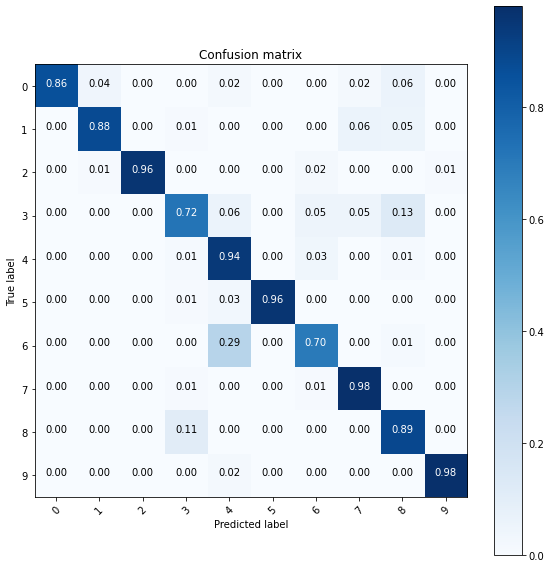

In [19]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(10), rotation=45)
    plt.yticks(tick_marks, range(10))

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(range(10)), normalize=True)

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(all_labels,all_preds)

0.8931718061674009